In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis.analysis.hbonds
from tqdm import tqdm
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import (
  HydrogenBondAnalysis as HBA)
print(MDAnalysis.__version__)


2.2.0


/Users/mirunaserian/opt/anaconda3/lib/python3.8/site-packages/MDAnalysis/analysis/hbonds/hbond_autocorrel.py:52: DeprecationWarning: This module was moved to MDAnalysis.analysis.hydrogenbonds.hbond_autocorrel; hbonds.hbond_autocorrel will be removed in 3.0.0.
  warnings.warn(wmsg, category=DeprecationWarning)


In [2]:
##gromacs configuration file###
gro_file_path = "/Volumes/miru_backup/jade_2synergy/popg/WF3_pg/md_0_1.tpr"
##compressed trajectory file###
xtc_file_path = "/Volumes/miru_backup/jade_2synergy/popg/WF3_pg/md_0_1_combined.xtc"

u = MDAnalysis.Universe(gro_file_path, xtc_file_path)

#### IMPORTANT  #######
# Specify number of peptides
pep_num = 4

if pep_num == '' or gro_file_path == '' or xtc_file_path == '':
    print("YOU FORGOT to specify your trajectory paths or number of peptides")

In [3]:
def get_peptide_range(res_start, pep_len, pep_num):
    """
    Creates a dictionary of the peptide and its respective residue ids e.g. {pep1:[1,2,3,4], pep2:[5,6,7]}

    Parameters
    ------------
    res_start: int
        The residue id of your first peptide residue
    pep_len: in
        Your peptide length
    pep_num: int
        Total number of peptides
    
    Return
    -----------
    pep_range: dict
        Dictionary of peptide numbers as keys and the lists of the respective residue ids as keys

    """
    pep_range = {}
    for i in range(pep_num):
        res_end = res_start+pep_len
        pep_range[f"pep{i+1}"] = list(range(res_start, res_end))
        res_start = res_end
    return pep_range

def get_aa_sequence(universe, pep_num):
    """
    Parameters
    ------------
    universe: MDAnalysis Universe object
    pep_num: int
        How many peptides the simulation contains
    
    Return
    ------------
    pep_num_dict: dict
        Dictionary of peptide numbers as keys and the lists of the respective residue ids as keys. 
    new_dict: dict
        Dictionary of residue_id: respective three-letter amino acid code e.g. {1: 'PHE', 2: 'LEU' ...}
    """
    protein_atoms = universe.select_atoms("protein")
    prot_residues = protein_atoms.residues
    res_names = prot_residues.resnames
    res_ids = prot_residues.residues.resids


    pep_len = int(len(res_ids)/pep_num)
    pep_num_dict = get_peptide_range(res_ids[0], pep_len, pep_num)
    seq_dict = dict(zip(res_ids, res_names))

    return pep_num_dict, seq_dict

In [5]:

def hbond_per_res(u, pep_num, peptide_name):
    hbonds = []
    pep_num_dict, seq_dict = get_aa_sequence(u, pep_num)

    for res_id, res_name in tqdm(seq_dict.items()):
        pep = [k for k, v in pep_num_dict.items() if res_id in v][0]

        h_bonds = HBA(u, update_selections=True, between=["resname POPE or resname POPG", f"resid {res_id}"])
        protein_hydrogens_sel = h_bonds.guess_hydrogens(f"resid {res_id}")

        protein_acceptors_sel = h_bonds.guess_acceptors(f"resid {res_id}")

        membrane_hydrogens_sel = h_bonds.guess_hydrogens("resname POPE or resname POPG")
        membrane_acceptors_sel = h_bonds.guess_acceptors("resname POPE or resname POPG")

        if res_name == "PRO":
            protein_hydrogens_sel = None
            h_bonds.hydrogens_sel = f"{membrane_hydrogens_sel}"
        else:
            h_bonds.hydrogens_sel = f"({protein_hydrogens_sel}) or ({membrane_hydrogens_sel})"
        h_bonds.acceptors_sel = f"({protein_acceptors_sel}) or ({membrane_acceptors_sel})"

        # You can change the step here. You can increase it so that it actually does the calculations for less time points
        # That will really shorten the amount of time needed to run (You can go higher, like up to 1000 or more)
        h_bonds.run(step=10000)
        
        hydrogen_count = h_bonds.count_by_time()
        time_count = h_bonds.times
        for i in range(len(time_count)):
            hbonds.append((pep, res_id, res_name, hydrogen_count[i], time_count[i]))

    pep_len = int(len(seq_dict)/pep_num)
    df = pd.DataFrame(hbonds) 
    df.columns = ["Peptide_num", "Resid", "Residue", "Hbonds", "Time"]
    df['Time'] = df['Time'].astype(float)/1000
    df['Time'] = df['Time'].astype(int)
    df = df.rename(columns={"Time": "Time (ns)"})
    df['Residue_number'] = df['Resid'].apply(lambda x: x%pep_len if  x%pep_len != 0 else pep_len)
    df.to_csv(f"hbonds_{peptide_name}.csv")
    return df

# CHANGE THE NAME OF my_pep to the name of your peptide - that will appear on the plot
df = hbond_per_res(u, pep_num, "my_pep")

100%|██████████| 96/96 [05:14<00:00,  3.28s/it]


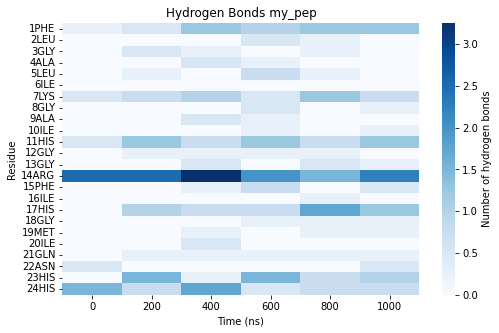

In [10]:
# Plotting
def plot_heatmaps(type_plot, peptide_name):
    """
    Parameters
    ------------
    peptide_name: str
        Name of peptie
    outuput_name: str
        Name of output/plot
    type_plot: str
        Choose one - average_by_peptide or average_by_residue or all 
    """

    # Read the CSV file 
    df = pd.read_csv(f"hbonds_{peptide_name}.csv")
    df = df.replace(np.nan, 0)
    df = df.drop(columns=["Unnamed: 0"])

    fig, ax = plt.subplots(figsize=(8,5))

    if type_plot == "average_by_peptide":
        df = df.groupby(['Peptide_num', 'Time (ns)'])['Hbonds'].mean().unstack(-1)
    elif type_plot == "average_by_residue":
        df['Res_amino'] = df['Residue_number'].astype(str) + df['Residue']
        df = df.groupby(['Res_amino', 'Time (ns)'])['Hbonds'].mean().unstack(-1).sort_values(
            by='Res_amino', key=lambda col: col.str[:-3].astype(int) ,ascending=True)


    else:
        df = df.groupby(['Resid','Time (ns)'])['Hbonds'].mean().unstack(-1)
        plt.figure(figsize=(10,18))

    sns.heatmap(df,cmap="Blues", cbar_kws={'label': "Number of hydrogen bonds"}, 
                yticklabels=df.index, ax=ax)\
                    .set_title(f"Hydrogen Bonds {peptide_name}")
    plt.savefig(f'hbonds_{peptide_name}',bbox_inches="tight")
    ax.set_ylabel('Residue')
# instead of "all" you can use average_by_peptide or average_by_residue to plot different averages
# instead of my pep use the name of your peptide - that would aappear on your plot 
plot_heatmaps("average_by_residue", "my_pep")
